In [ ]:
!pip install faker
!pip install tqdm
!pip install keras_application
!pip install keras_preprocessing
!pip install keras

ERROR: Could not find a version that satisfies the requirement keras_application (from versions: none)
ERROR: No matching distribution found for keras_application


In [ ]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

import random
from tqdm import tqdm

from faker import Faker
import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

from keras.applications import MobileNetV2

from keras.layers import *
from keras.models import Model

In [ ]:
#Variablen
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

# Funktionen

In [ ]:
# Function to viz the annotation

BildGrößeX = 512
BildGrößeY = 512

grid_w = 12
grid_h = 12

def markup(BildWeg, annotations):
  # laden der Zusatdaten
  Bild = cv2.imread(BildWeg)
  x_sl = BildGrößeX/Bild.shape[1]
  y_sl = BildGrößeY/Bild.shape[0]

  Bild = cv2.resize(Bild, (BildGrößeX, BildGrößeY))

  # laden der Infos
  Y = np.zeros((grid_h,grid_w,1,5))

  for annotation in annotations:
      # Draw bbox
      # "bbox": [37.59, 433.64, 251.07, 20.38]
    xmin = annotation['bbox'][0] * x_sl
    xmax = (annotation['bbox'][0] + annotation['bbox'][2]) * x_sl

    ymin = annotation['bbox'][1] * y_sl
    ymax = (annotation['bbox'][1] + annotation['bbox'][3]) * y_sl
    
    w = (xmax - xmin)/BildGrößeX
    h = (ymax - ymin)/BildGrößeY
    
    x = ((xmax + xmin)/2)/BildGrößeX
    y = ((ymax + ymin)/2)/BildGrößeY
    x = x * grid_w
    y = y * grid_h

    Y[int(y),int(x),0,0] = 1
    Y[int(y),int(x),0,1] = x - int(x)
    Y[int(y),int(x),0,2] = y - int(y)
    Y[int(y),int(x),0,3] = w
    Y[int(y),int(x),0,4] = h

  return Bild, Y

In [ ]:
# text ("1"), title ("2"), list ("3"), table ("4"), figure ("5").
# "bbox": [37.59, 360.34, 251.07, 41.36]

def loadData(String1, StringZusatz):
  
  x = []
  y = []

  with open(String1, 'r') as fp:
      samples = json.load(fp)
  # Index images
  images = {}
  for image in samples['images']:
      images[image['id']] = {'file_name': StringZusatz + image['file_name'], 'annotations': []}
  for ann in samples['annotations']:
      images[ann['image_id']]['annotations'].append(ann)

  # Ausschneiden und ausgeben
  for i, (_, image) in enumerate(images.items()):
    try:
      TempImage, ZielMuster = markup(image['file_name'], image['annotations'])
      x.append(TempImage)
      y.append(ZielMuster)
    except Exception:
      continue

  x = np.array(x)
  y = np.array(y)

  print(x.shape)
  print(y.shape)

  return x, y

# Bau des Models

In [ ]:
def yolo_model(input_shape):
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same', name="ErstesCNNLayer")(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same', name="ZweitesCNNLayer")(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info), name="Finale")(conv)
    
    model = Model(inp,final)
    
    return model

In [ ]:
model = yolo_model((512,512,3))

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


# utils

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#checkpoint
checkpoint = ModelCheckpoint('model1/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

In [ ]:
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

# Training


In [ ]:
def openTar(Name):
  tar = tarfile.open(Name)
  tar.extractall()
  tar.close()


In [ ]:
x = []
y = []

In [ ]:
# Daten Laden
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz --output "train-0.tar.gz"
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-1.tar.gz --output "train-1.tar.gz"
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-2.tar.gz --output "train-2.tar.gz"
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz --output "labels.tar.gz"

openTar("train-0.tar.gz")
openTar("train-1.tar.gz")
openTar("train-2.tar.gz")
openTar("labels.tar.gz")

StringToJSON = 'publaynet/train.json'
StringToFolder = 'publaynet/train/'

x,y = loadData(StringToJSON, StringToFolder)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  3 12.6G    3  445M    0     0  3401k      0  1:05:11  0:02:14  1:02:57 3778k^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 12.6G    0 78.0M    0     0  6008k      0  0:36:55  0:00:13  0:36:42 6664k

In [ ]:
csv_logger = CSVLogger('log.csv', append=True, separator=';')

history = model.fit(x, y, epochs= 32 ,batch_size = 4, validation_split=0.3 , callbacks=[csv_logger, checkpoint])

model.save('model')

Epoch 1/30
20/20 [==============================] - 40s 2s/step - loss: 1.7645 - accuracy: 0.7953
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20/20 [==============================] - 25s 1s/step - loss: 0.3845 - accuracy: 0.9424
Epoch 3/30
20/20 [==============================] - 25s 1s/step - loss: 0.3642 - accuracy: 0.9489
Epoch 4/30
20/20 [==============================] - 26s 1s/step - loss: 0.3374 - accuracy: 0.9544
Epoch 5/30
20/20 [==============================] - 25s 1s/step - loss: 0.3042 - accuracy: 0.9591
Epoch 6/30
20/20 [==============================] - 25s 1s/step - loss: 0.2978 - accuracy: 0.9614
Epoch 7/30
20/20 [==============================] - 25s 1s/step - loss: 0.2943 - accuracy: 0.9623
Epoch 8/30
20/20 [==============================] - 25s 1s/step - loss: 0.2919 - accuracy: 0.9621
Epoch 9/30
20/20 [==============================] - 25s 1s/step - loss: 0.2941 - accuracy: 0.9624
Epoch 10/30
20/20 [==============================] - 25s 1s/step - loss: 0.2932 - accuracy: 0.9625
Epoch 11/30
20/20 [==============================] - 25s 1s/step - loss: 0.2916 - accuracy: 0.9625
Epoch 12/30
20/20 [==========

# Auswertung


In [ ]:
plt.xkcd()

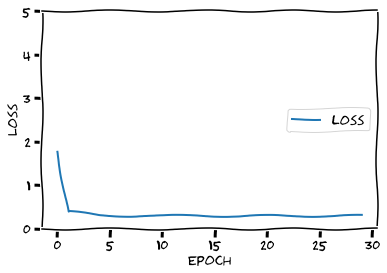

In [ ]:
#plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='center right')
plt.show()

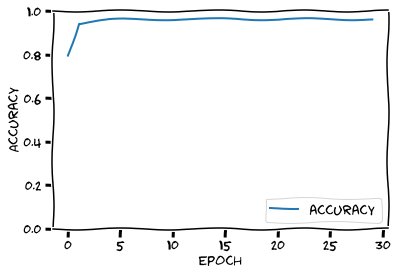

In [ ]:
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Analyse

In [ ]:
# Daten Laden
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/examples.tar.gz --output "examples.tar.gz"

openTar("examples.tar.gz")

StringToJSON = 'examples/samples.json'
StringToFolder = 'examples/'

x,y = loadData(StringToJSON, StringToFolder)